# Demo for the `isac-uav-dataset`

## Preparation

To run this notebook, make sure you copy the dataset files (with `*.h5`-suffix) into the same directory as this notebook.  
E.g., if the notebook is run from the `snippets`-directory, you can link your files here with:

```bash
ln -s ../*.h5 .
```

The following imports are required to run this notebook.

In this notebook, we import the `UAVDataset`-class from `snippets/uavdataset.py` to get easy access to the dataset files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.pyplot.ion()

try:
    from uavdataset import UAVDataset
except ImportError:
    raise ImportError(f"Failed to import `UAVDataset` from `uavdataset.py`. Please make sure the `uavdataset.py` is in the same directory as this notebook.")

## Delay-Doppler Map of single Rx

Here we create two plots of Delay-Doppler Maps. One with a simple clutter filter, and one without. We do so by extending the `UAVDataset`-class with a few method that take care of getting and postprocessing the data for us. The input parameters are now:

| Parameter | Description |
| --- | --- |
| `channelfile` | The path to the channel file |
| `targetfile` | The path to the target file |
| `window_slowtime` | The window size in slowtime in number of samples (int). |
| `filter_clutter` | Whether to filter clutter or not (bool). |

In [101]:
class UAVDatasetMaps(UAVDataset):
    def __init__(self, channelfile, targetfile, window_slowtime: int, filter_clutter: bool = True):
        super().__init__(channelfile, targetfile)
        self.window_slowtime = window_slowtime
        self.filter_clutter = filter_clutter
        
    def _get_channel(self, start_idx: int) -> np.ndarray:
        x = self.channel
        if start_idx > x.shape[0] - self.window_slowtime:
            raise ValueError(
                "Start index must be smaller than the number of slowtime samples minus the window size.")

        stop_idx = start_idx + self.window_slowtime
        if self.filter_clutter:
            stop_idx += 1
            
        x = x[start_idx:stop_idx, :]
        
        if self.filter_clutter:
            x = np.diff(x, n=1, axis=0)
            
        y = np.fft.fftshift(np.fft.fft(np.fft.ifft(x, axis=1, norm="ortho"), axis=0, norm="ortho"), axes=0)
        y /= np.linalg.norm(y)

        return y
    

    def _get_groundtruth(self, start_idx: int):
        if start_idx > len(self) - self.window_slowtime:
            raise ValueError(
                "Start index must be smaller than the number of slowtime samples minus the window size.")

        delay = self.groundtruth[start_idx+self.window_slowtime//2, 0]
        doppler = self.groundtruth[start_idx+self.window_slowtime//2, 1]

        return np.array([delay, doppler])
    
    def get(self, start_idx: int):
        data = self._get_channel(start_idx)
        groundtruth = self._get_groundtruth(start_idx)
        return data, groundtruth


Next, we define two instances of the class. One for the clutter-filtered data and one for the unfiltered data.

In [125]:
scenario = "8to7_H30_V11"
receiver = "VGH0"
window = 100

Maps = UAVDatasetMaps(
    channelfile=f"{scenario}_{receiver}_channel.h5",
    targetfile=f"{scenario}_{receiver}_target.h5",
    window_slowtime=window,
    filter_clutter=False,
)
MapsFilt = UAVDatasetMaps(
    channelfile=f"{scenario}_{receiver}_channel.h5",
    targetfile=f"{scenario}_{receiver}_target.h5",
    window_slowtime=window,
    filter_clutter=True,
)

Then we define some parameters for the plotting, namely, the style for the groundtruth marker and the index to plot.

In [ ]:
MARKER_STYLE = dict(
    linestyle="none",
    markersize=15,
    marker="o",
    fillstyle="none",
    markeredgewidth=1.5,
    color="none",
    markerfacecolor="none",
    markerfacecoloralt="none",
    markeredgecolor="white",
)

idx = 90000

### Plot without clutter filter

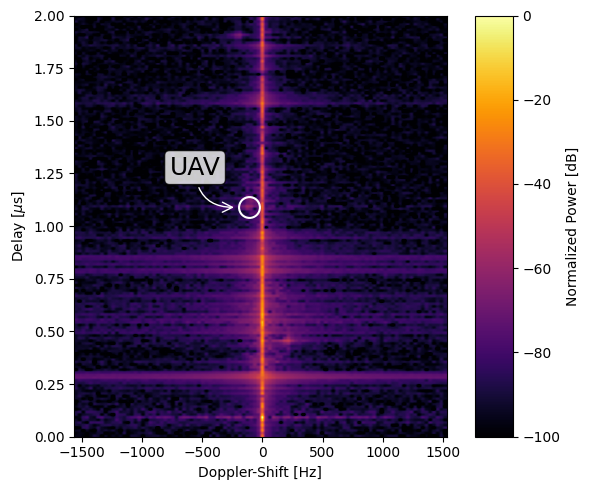

In [138]:
data, groundtruth = Maps.get(idx)

fig, ax = plt.subplots(
    1, 2,
    figsize=(6, 5),
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 0.1]}
)
ax[0].imshow(20*np.log10(np.abs(data[:, :160])).T, aspect="auto", origin="lower",
             cmap="inferno", vmin=-100, vmax=0, extent=[-1/(2*320e-6), +1/(2*320e-6)-1/(window*320e-6), 0, 2])
ax[0].plot(groundtruth[1], groundtruth[0]*1e6, **MARKER_STYLE)
ax[0].set_ylabel("Delay [$\mu$s]")
ax[0].set_xlabel("Doppler-Shift [Hz]")
ax[0].annotate("UAV", 
                fontsize=18,
                xy=(groundtruth[1]-100, groundtruth[0]*1e6), 
                xytext=(-30, 20),
                textcoords="offset points", 
                ha="center", 
                va="bottom",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.8),
                arrowprops=dict(
                    arrowstyle="->", 
                    connectionstyle="arc3,rad=0.5",
                    color="white"
                ),
)
cbar = plt.colorbar(ax[0].get_images()[0],
                    cax=ax[1], orientation="vertical")
cbar.set_label("Normalized Power [dB]")
plt.show()

### Plot with Clutter Filter

Now we plot the data with the simple clutter filter. We also adjust the colobar range for the new data. 

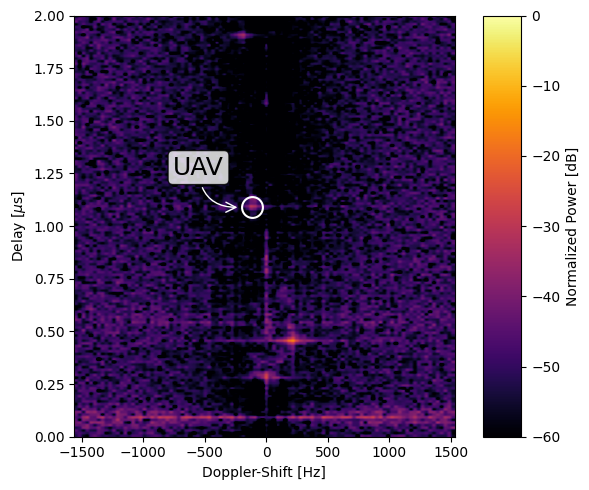

In [139]:

data_filt, groundtruth_filt = MapsFilt.get(idx)

fig, ax = plt.subplots(
    1, 2,
    figsize=(6, 5),
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 0.1]}
)
ax[0].imshow(20*np.log10(np.abs(data_filt[:, :160])).T, aspect="auto", origin="lower",
             cmap="inferno", vmin=-60, vmax=0, extent=[-1/(2*320e-6), +1/(2*320e-6)-1/(window*320e-6), 0, 2])
ax[0].plot(groundtruth[1], groundtruth[0]*1e6, **MARKER_STYLE)
ax[0].set_ylabel("Delay [$\mu$s]")
ax[0].set_xlabel("Doppler-Shift [Hz]")
ax[0].annotate("UAV", 
                fontsize=18,
                xy=(groundtruth[1]-100, groundtruth[0]*1e6), 
                xytext=(-30, 20),
                textcoords="offset points", 
                ha="center", 
                va="bottom",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.8),
                arrowprops=dict(
                    arrowstyle="->", 
                    connectionstyle="arc3,rad=0.5",
                    color="white"
                ),
)

cbar = plt.colorbar(ax[0].get_images()[0],
                    cax=ax[1], orientation="vertical")
cbar.set_label("Normalized Power [dB]")

plt.subplots_adjust()
plt.show()